In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import cv2

# Logger

In [2]:
log_path = 'results/'

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('Tinyssimo with WiderFace Dataset')

# Folders

In [5]:
!pwd

/home/jovyan/Gonzalo_Moreno/code/tinyssimo_widerface


In [6]:
ds_dir = '../../../Carlos_Gonzalez/YOLO/WiderFace/'

train_imgs = ds_dir + 'images/train/'
train_labels = ds_dir + 'labels/train/'

val_imgs = ds_dir + 'images/valid/'
val_labels = ds_dir + 'labels/valid/'

print(f'Train 1 dir: {os.listdir(train_imgs)[:3]}')
print(f'Test dir: {os.listdir(val_imgs)[3]}')

Train 1 dir: ['image_1645.jpg', 'image_10644.jpg', 'image_4405.jpg']
Test dir: image_1276.jpg


# Config

In [7]:
CLASSES = ["face"]

IMG_DIM = {'W':88, 'H':88} # (W, H)

SX = 4
SY = 4
B = 2 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Utils

In [8]:
def yolo2pixel(bbox):
    '''
    Transforms yolo coordinates of the box to pixel coordinates. 
    
    Arguments:
        - bbox: yolo coordinates [xc, yc, width, height]
    
    Returns: 
        - pixel coordinates [xmin, xmax, ymin, ymax]
    '''
    xc = bbox[0]
    yc = bbox[1]
    width = bbox[2]
    height = bbox[3]
      
    xmin = xc - (width/2)          
    xmax = xc + (width/2)         
    ymin = yc - (height/2)            
    ymax = yc + (height/2)
        
    nbox = [xmin, ymin, xmax, ymax]
    
    return nbox


def iou_tensor(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def nms_yv1(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou_tensor(
                torch.tensor(chosen_box[:4]),
                torch.tensor(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def nms_yv1_getBBoxes(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_id, score, xc, yc, w, h] Output of outcell_2_outboxes       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou_tensor(
                torch.tensor(chosen_box[2:6]),
                torch.tensor(box[2:6]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



def mAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []
    avg_prec = {}

    # Precision and Recall for each class
    cls_prec = {}
    cls_rec = {}

    # used for numerical stability later on
    epsilon = 1e-6

    #for c in range(num_classes):
    for c in tqdm(range(num_classes), desc ="mAP:@.5"):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        #print(f'Detections of class {c}: {detections}')
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        
        #print(f'Amount bboxes of class {c}: {amount_bboxes}')

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #print(f'Amount bboxes of class {c} converted: {amount_bboxes}')
        
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
       
        #print(f'Total true bboxes of class {c}: {total_true_bboxes}')
        
        # If none exists for this class then we can safely skip
        # Maybe removing this is enough to take into account False Positives
        # for images with no objects
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_tensor(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )
                # iou, _, _ = ut.iou(detection[3:], 
                #                    gt[3:]) 

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #print(f'True Positives class {c}: {TP}')
        #print(f'False Positives class {c}: {FP}')

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        if precisions.numel() > 0:
            #cls_prec.update({c: precisions[-1].numpy()})
            cls_prec.update({c: precisions[-1].item()})
        else:
            cls_prec.update({c: 0.})
        if recalls.numel() > 0:
            #cls_rec.update({c: recalls[-1].numpy()})
            cls_rec.update({c: recalls[-1].item()})
        else:
            cls_rec.update({c: 0.})

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        avg_prec.update({c: torch.trapz(precisions, recalls)})

    mAP = sum(average_precisions) / (len(average_precisions) + epsilon)

    #return mAP, average_precisions, cls_prec, cls_rec
    return (mAP, 
            avg_prec,
            cls_prec, 
            cls_rec)


def get_bboxes(
    loader,
    model,
    SX,
    SY,
    B,
    C,
    mask,
    iou_threshold,
    threshold,
    device,
    box_format="midpoint"):
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    #for batch_idx, (imgs, labels, _, _) in enumerate(loader):
    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(imgs)

        batch_size = imgs.shape[0]
        true_bboxes = outcell_2_outboxes(out_cells=labels, 
                                         SX=SX, SY=SY, B=B, C=C, 
                                         mask=mask, 
                                         device='cpu', # Changed to cpu
                                         is_pred=False)
        bboxes = outcell_2_outboxes(out_cells=predictions, 
                                    SX=SX, SY=SY, B=B, C=C, 
                                    mask=mask, 
                                    device='cpu', # Changed to cpu
                                    is_pred=True)

        for idx in range(batch_size):
            #nms_boxes = nms_yv1(
            nms_boxes = nms_yv1_getBBoxes(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format, # Midpoint, to use iou_tensor inside
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred, as bboxes have Conf = 1 and the rest are 0
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def outcell_2_outboxes(out_cells, SX, SY, B, C, mask, device, is_pred = True):
    '''
    Convert batch of cells to batch of boxes: out_cells must be of shape (BATCH_SIZE, SX, SY, B*5+C) 
        [xcel, ycel, w, h, conf, class_0, class_1] -> [pred_class, score, xc, yc, w, h]
    
    Arguments:
        - out_cells: labels at loader output or predictions at model output
            Format: [xcel, ycel, w, h, conf, class_0, class_1]
    Return:
        - all_bboxes: list of bounding boxes
            Format: [[bboxes idx 0], [bboxes idx 1], ... [bboxes idx BATCH_SIZE-1]]
    '''

    out_cells = out_cells.to(device) # TAKE A LOOK TO CPU DECISION

    out_cells[out_cells <= 0] = 0 # Zeroing all negative values. Avoid (-conf * -class_id) = +score
    #out_cells[out_cells >= 1] = 1 # Clamping all values to 1. Avoid being out of the image. Maybe afterwards, although it does not hurt here.
                                   # This is due to yolo2pixel transformation, which could led to out of image values, depending on (w, h)

    batch_size = out_cells.shape[0]
    if is_pred:
        out_cells = out_cells.reshape(batch_size, SY, SX, B*5+C)
    else:
        out_cells = out_cells.reshape(batch_size, SY, SX, 5+C)
    
    # With 2 BBoxes, choose the one with highest confidence. How highest IOU, without label?
    if (B>1 and is_pred):
        '''
        2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, face]
        '''
        bbox1 = out_cells[..., :4]
        bbox2 = out_cells[..., 5:9]
        score = torch.cat((out_cells[..., 4:5],out_cells[..., 9:10]), dim=-1)
        best_score, idx = torch.max(score, dim=-1, keepdim=True)

        bestbbox = (1-idx)*bbox1 + idx*bbox2

        #class_prob = a[..., 10:12] # Esto no hace falta, se hace debajo
        #cls_pred = class_prob.argmax(dim=-1, keepdim=True)
        out_cells = torch.cat((bestbbox, best_score, out_cells[..., 10:11]), dim=-1)
        
    
    # All cells are converted to boxes. Format will be [xc, yc, w, h, conf, face]
    boxes = cell2boxes(cells = out_cells, mask = mask)

    # ================================================================================================================== #
    #                                                                                                                    #
    #     Convert [xc, yc, w, h, conf, class_0, class_1] to [pred_class, score, xc, yc, w, h]                            #
    #         Identify class predicted: class_0 > class_1 ??? or the opposite                                            #
    #         Multiply (conf * class_id) to get score and compare to threshold afterwards. It will be 1 for ground truth #
    #                                                                                                                    #
    # ================================================================================================================== #
    classes = boxes[...,5:6].argmax(-1).unsqueeze(-1) # Indices of class predictes, matching class_id: index 0 -> smoke, class id = 0 // same for fire
    #print(f'Tensor of classes predicted\n {classes}')   
    
    # If SOFTMAX is used, there is no need to multiply conf * class_prob
    # scores = ( boxes[...,4].unsqueeze(-1) ) * boxes[...,5:7] # score = confidence * [class_0_prob, class_1_prob]
    # scores, _ = torch.max(scores, dim=-1, keepdim=True) # Get maximum values -> score of class predicted
    scores = boxes[..., 4:5]
    #print(f'Scores together\n {scores}')     
    
    out_boxes = torch.concat((classes, scores, boxes[...,:4]), dim=-1) # Concat all data
    #print(f'Final Output {out_boxes}')    

    # =========================================== #
    #                                             #
    #             Convert boxes to List           #
    #                                             #
    #    [[bboxes idx 0] , [bboxes idx 1], etc]   #
    #                                             #
    # =========================================== #
    all_bboxes = []

    for ex_idx in range(batch_size):
        bboxes = []

#         for bbox_i in range(SX):
#             for bbox_j in range(SY):
#                 bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_i, bbox_j, :]])
        for bbox_i in range(SX):
            for bbox_j in range(SY):
                bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_j, bbox_i, :]])     
        all_bboxes.append(bboxes)
    
    return all_bboxes


def cell2boxes(cells, mask):
    '''
    Converts cells to boxes using the cell2box_mask and broadcasting over batches
    In targets, sum only when score = 1

    Arguments:
        - cells: cells to convert, as yield by Dataloader in batches
        - mask: mask used for conversion

    Return:
        - cells converted to boxes
    '''

    #out_boxes = cells.clone().detach()
    out_boxes = cells.detach().clone()
    out_boxes[...,0:1] = (out_boxes[...,0:1] + mask[...,0:1])/SX 
    out_boxes[...,1:2] = (out_boxes[...,1:2] + mask[...,1:2])/SY 

    return out_boxes


def plot_preds(ori_img, img_w, img_h, nms_preds, names, colors):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''
    
    pic = ori_img.copy()
    
    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        box = np.array(yolo2pixel([xc,yc,w,h]))
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w
        box[3] = box[3]*img_h
        box = box.round().astype(np.int32).tolist()
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic,box[:2],box[2:],color,2) # 1 -> rectangle thickness
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],thickness=1)  # 0.5 -> font size

    return pic

def save_log(epochs, 
             train_total_loss,
             train_box_loss,
             train_class_loss,
             train_confidence_loss,
             train_noobj_loss,
             train_mAP,
             train_class_AP,
             train_class_precision,
             train_class_recall,
             val_total_loss,
             val_box_loss,
             val_class_loss,
             val_confidence_loss,
             val_noobj_loss,
             val_mAP,
             val_class_AP,
             val_class_precision,
             val_class_recall,
             log_file_dst):
    
    '''
    Create a dictionary with all metrics
    Save the dictionary as excel file with Pandas
    '''
    
    epoch_range = range(epochs)
    log_file = {}
    log_file.update({"epoch": epoch_range})
    
    # Train Losses
    log_file.update({"train_total_loss": train_total_loss})
    log_file.update({"train_box_loss": train_box_loss})
    log_file.update({"train_class_loss": train_class_loss})
    log_file.update({"train_confidence_loss": train_confidence_loss})
    log_file.update({"train_noobj_loss": train_noobj_loss})
    
    # Train mAP, Class AP, Precision, Recall
    train_mAP_log = []
    for e in train_mAP:
        #train_mAP_log.append(e.numpy())
        #train_mAP_log.append(e)
        train_mAP_log.append(e.item())
    log_file.update({"train_mAP": train_mAP_log})
    
    train_smk_AP = []
    train_fire_AP = []
    for e in train_class_AP:
        #train_smk_AP.append(e[0].numpy())
        #train_smk_AP.append(e[0])
        train_smk_AP.append(e[0].item())
        #train_fire_AP.append(e[1].numpy())
        #train_fire_AP.append(e[1])
        train_fire_AP.append(e[1].item())
    log_file.update({"train_smk_AP": train_smk_AP})
    log_file.update({"train_fire_AP": train_fire_AP})
    
    
    train_smk_precision = []
    train_fire_precision = []
    for e in train_class_precision:
        #train_smk_precision.append(e[0].numpy())
        train_smk_precision.append(e[0])
        #train_fire_precision.append(e[1].numpy())
        train_fire_precision.append(e[1])
    log_file.update({"train_smk_precision": train_smk_precision})
    log_file.update({"train_fire_precision": train_fire_precision})
        
    train_smk_recall = []
    train_fire_recall = []
    for e in train_class_recall:
        #train_smk_recall.append(e[0].numpy())
        train_smk_recall.append(e[0])
        #train_fire_recall.append(e[1].numpy())
        train_fire_recall.append(e[1])
    log_file.update({"train_smk_recall": train_smk_recall})
    log_file.update({"train_fire_recall": train_fire_recall})
    
    # Validation Losses
    log_file.update({"val_total_loss": val_total_loss})
    log_file.update({"val_box_loss": val_box_loss})
    log_file.update({"val_class_loss": val_class_loss})
    log_file.update({"val_confidence_loss": val_confidence_loss})
    log_file.update({"val_noobj_loss": val_noobj_loss})
    
    # Val mAP, Class AP, Precision, Recall
    val_mAP_log = []
    for e in val_mAP:
        #val_mAP_log.append(e.numpy())
        val_mAP_log.append(e.item())
    log_file.update({"val_mAP": val_mAP_log})
    
    val_smk_AP = []
    val_fire_AP = []
    for e in val_class_AP:
        val_smk_AP.append(e[0].item())
        val_fire_AP.append(e[1].item())
    log_file.update({"val_smk_AP": val_smk_AP})
    log_file.update({"val_fire_AP": val_fire_AP})
    
    val_smk_precision = []
    val_fire_precision = []
    for e in val_class_precision:
        val_smk_precision.append(e[0])
        val_fire_precision.append(e[1])
    log_file.update({"val_smk_precision": val_smk_precision})
    log_file.update({"val_fire_precision": val_fire_precision})
    
    val_smk_recall = []
    val_fire_recall = []
    for e in val_class_recall:
        val_smk_recall.append(e[0])
        val_fire_recall.append(e[1])
    log_file.update({"val_smk_recall": val_smk_recall})
    log_file.update({"val_fire_recall": val_fire_recall})
    
    df = pd.DataFrame(log_file)
    df.to_excel(log_file_dst)

# Dataset

# WiderFace Dataset

In [9]:
class WiderFace(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, face]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, face]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, 
                 SX, SY, C, 
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.SX = SX
        self.SY = SY
        self.C = C
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xc, yc, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        xmin = xc - w/2
        ymin = yc - h/2
        xmax = xc + w/2
        ymax = yc + h/2
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_5 = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_mtx = np.zeros((self.SY, self.SX))
                overlapping_object = 0

                one_bboxes = []
                one_labels = []
            
                with open(label) as f:
                    lines = f.readlines()

                    # Restrict to 3 boxes per sample
                    if len(lines) > 5:
                        more_than_5 += 1
                        continue
                        
                    for line in lines:
                        class_id, x, y, w, h = line.strip().split()
                        class_id = int(class_id)
                        box = np.array([x, y, w, h]).astype(np.float32)
                        x, y, w, h = box[0], box[1], box[2], box[3]
                        box_ok = self.__bbox_check__([x, y, w, h])
                        x, y, w, h = box_ok[0], box_ok[1], box_ok[2], box_ok[3]
                        i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                        if label_mtx[i, j] == 1:
                            overlapping_object = 1
                            overlapping_rem += 1
                            #print(f'Removed {label} due to overlapping object in cell {i, j}')
                            break
                        else:
                            label_mtx[i, j] = 1
                            one_bboxes.append([x, y, w, h])
                            # face
                            if class_id == 0:
                                one_labels.append(0)
                            else:
                                print(f'File {label} errored in cell {i, j}')

                    if overlapping_object == 0:
                        # Padding to SX*SY labels and bounding boxes, so you can store tensors
                        # Label -1 indicates no box
                        for idx in range(self.SX*self.SY - len(one_labels)):
                            one_bboxes.append([0, 0, 0, 0])
                            one_labels.append(-1)
                        # print(f'\nBboxes and Labels of image {image_path}')
                        # print("Bboxes")
                        # for box in one_bboxes:
                        #     print(box)
                        # print("Labels")
                        # for label in one_labels:
                        #     print(label)
                        bboxes.append(one_bboxes)
                        labels.append(one_labels)
                        images.append(image_path)
        
        print(f'Removed wrong images: {wrong_imgs}')
        print(f'Removed due to overlapping: {overlapping_rem}')
        print(f'Removed due to more than 5: {more_than_5}')
        logger.info(f'Removed wrong images: {wrong_imgs}')
        logger.info(f'Removed due to overlapping: {overlapping_rem}')
        logger.info(f'Removed due to more than 5: {more_than_5}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels

    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = (img / 255.)
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# Visualize some examples with a Test Train Loader

In [10]:
view_train_imgs = val_imgs
view_train_labels = val_labels

In [11]:
VIEW_BATCH_SIZE = 16
VIEW_NUM_WORKERS = 1
VIEW_PIN_MEMORY = True

VIEW_S = 4
VIEW_C = 1
VIEW_B = 1

VIEW_IMG_W = 88
VIEW_IMG_H = 88

# Data Aug Function

In [12]:
view_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSizedBBoxSafeCrop(height=int(1.4*VIEW_IMG_H),
                              width= int(1.4*VIEW_IMG_W),
                              erosion_rate=0.6,
                              p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, p=0.2),
    A.Blur(blur_limit=(3,3), p=0.2),
    A.CLAHE(clip_limit=2.0, p=0.3),
    # Shifting, scaling and rotation could dive 2 bbox inside same grid...
    #A.ShiftScaleRotate(rotate_limit=5, p=0.2),
    A.Resize(VIEW_IMG_H, VIEW_IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', 
                            #min_area=6*6, 
                            #min_visibility=0.05, 
                            label_fields=['class_labels']))


# WiderFace Dataset

In [13]:
logger.info('\nBefore View Dataset Examples')

view_widerface_dataset = WiderFace(img_h = VIEW_IMG_H,
                                   img_w = VIEW_IMG_W,
                                   img_dir = view_train_imgs,
                                   label_dir = view_train_labels,
                                   SX = VIEW_S,
                                   SY = VIEW_S,
                                   C = VIEW_C,
                                   transform=view_transform)

Removed wrong images: 0
Removed due to overlapping: 330
Removed due to more than 5: 0


# View Loader

In [14]:
view_loader = DataLoader(dataset=view_widerface_dataset,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=VIEW_NUM_WORKERS,
                         pin_memory=VIEW_PIN_MEMORY,
                         shuffle=True,
                         drop_last=False)

# Utils to Plot

In [15]:
def get_bboxes_from_label_mtx(label_mtx):

    c2b_mtx = np.zeros((VIEW_S, VIEW_S, 2))
    for j in range(VIEW_S):
        for i in range(VIEW_S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    label_mtx = label_mtx.numpy()
    label_xy = label_mtx[..., :2]
    label_rest = label_mtx[..., 2:]

    c2b_xy = (c2b_mtx+label_xy)/VIEW_S
    out = np.concatenate((c2b_xy, label_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_list = np.reshape(out, (VIEW_S*VIEW_S, 5+VIEW_C))

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]==1]

    return bboxes_list


def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'face'}
    colors = {'face': (0,255,255)}
    # NEVER remove copy() or use np.ascontiguousarray()
    pic = ds_img.numpy().copy()       

    for i,(xc,yc,w,h,score,face) in enumerate(nms_preds):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w-1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h-1 # avoid out of limits due to rounding
        box = box.round().astype(np.uint8).tolist()
        if face == 1:
            cls_id = 0
        else:
            print("Error: no valid class")
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 1) 
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],
                    thickness=1)  # 0.5 -> font size

    return pic

# Plot

/tmp/ipykernel_836/3091386464.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(w_pad=100)


<Figure size 6400x3200 with 0 Axes>

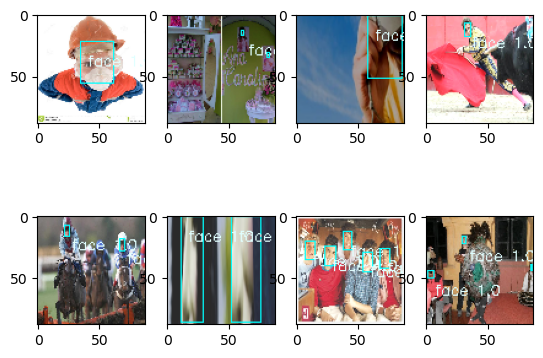

In [16]:
#for i, (img, label_mtx, img_path) in enumerate(view_loader):

plt.figure(figsize=(64, 32))

for i, (img, label_mtx) in enumerate(view_loader):
    #print(f'Batch id = {i}')

    plt.subplots(2,4)

    for idx in range(VIEW_BATCH_SIZE):
        #print(f'Index inside batch = {idx}')
        #print(img_path[idx])
        bboxes = get_bboxes_from_label_mtx(label_mtx[idx])
        #print(bboxes)
        img_ds = plot_pytorch(img[idx].permute(1, 2, 0), 
                              VIEW_IMG_W, 
                              VIEW_IMG_H, 
                              bboxes)
        plt.subplot(2, 4, idx+1)
        plt.imshow(img_ds)
        #plt.imshow(img[idx].permute(1, 2, 0))
        
        if (idx == 7):
            break
    #if (idx == 1):
    plt.tight_layout(w_pad=100)
    plt.show()
    break

# BED

In [17]:
class BED(nn.Module):
    def __init__(self, num_classes, S, B, in_channels=3):
        super(BED, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.S = S
        self.B = B
        
        self.model = self.__create_BED__()

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock Out
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    def forward(self, x):
        x_out = self.model(x)
        x = x_out.permute(0, 2, 3, 1)
        if self.B == 1:
            class_softmax = torch.softmax(x[..., 5:7], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:5]), class_softmax), dim=-1)  
        else:
            class_softmax = torch.softmax(x[..., 10:12], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:10]), class_softmax), dim=-1)
        return x 

# Tinyssimo

In [18]:
class Tinyssimo_fixed_88x88_BatchNorm(nn.Module):
    def __init__(self, in_channels=3, num_boxes=1, num_classes=C):
        super(Tinyssimo_fixed_88x88_BatchNorm, self).__init__()
        self.in_channels = in_channels
        self.C = num_classes
        self.B = num_boxes
        self.tiny_model = self.__create_tinyssimo__()
    
    def __create_tinyssimo__(self):
        tinyssimo_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 1
            nn.Conv2d(self.in_channels, 16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # CNNBlock 2
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # CNNBlock 3
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # CNNBlock 4
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            # CNNBlock 5
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # HEAD
            nn.Flatten(),
            nn.Linear(in_features=128*2*2, out_features=256), # 2 and 2 are dims b4 FC layer
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(in_features=256, 
                      out_features=SX*SY*(B*5+C)),
        )
        return tinyssimo_model 

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        y = self.tiny_model(x)
        y = y.view(-1, SY, SX, 5*self.B+self.C)
        y = torch.sigmoid(y[..., 0:(5*self.B+self.C)])
        return y 

# Yolo Loss 2BB

In [19]:
class YoloLossMSE_2BBox(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossMSE_2BBox, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        
        self.last_box_xy = 0.0
        self.last_box_wh = 0.0
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0

    def forward(self, ground_truth, predictions):

        #predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)
        assert predictions.shape == (BATCH_SIZE, self.SY, self.SX, self.B*5 + self.C) 
        assert ground_truth.shape == (BATCH_SIZE, self.SY, self.SX, 5 + self.C) 
        
        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5] == 1
        pred_box1 = exists_box*predictions[..., 0:4]
        pred_box2 = exists_box*predictions[..., 5:9]
        target_box = exists_box*ground_truth[..., :4]

        # =========================== #
        #            IOU              #
        # =========================== #
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou1 = iou_tensor(boxes_preds=pred_box1, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 1\n{iou1}')
        iou2 = iou_tensor(boxes_preds=pred_box2, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 2\n{iou2}')
        ious = torch.cat([iou1, iou2], dim=-1)
        #print(f'IOUs\n{ious}')
        
        iou_maxes, best_boxes = torch.max(ious, keepdim=True, dim=-1)
        pred_boxes = best_boxes*pred_box2[..., :4]+(1-best_boxes)*pred_box1[..., :4]

        # =============== #
        #   Center Loss   #
        # =============== #
        xy_loss = self.mse(pred_boxes[..., :2],
                           target_box[..., :2])
        self.last_box_xy = xy_loss.item()
        #print('\nCenter Loss', center_loss)

        # ====================== #
        #   Width, Height Loss   #
        # ====================== #
        # Use torch.sign to undo torch.abs and preserve gradient sign 
        wh_loss = self.mse(torch.sign(pred_boxes[..., 2:4])*torch.sqrt(torch.abs(pred_boxes[..., 2:4])+1e-6),
                           torch.sqrt(target_box[..., 2:4]))
        #print(f'WH Loss {wh_loss:.6f}')
        self.last_box_wh = wh_loss.item()

        # =================== #
        #   Confidence Loss   #
        # =================== #
        conf_pred_box = exists_box*( best_boxes*predictions[..., 9:10] + (1-best_boxes) * predictions[..., 4:5])
        #print(f'Conf pred boxes \n {conf_pred_box}')
        # conf_loss = self.mse(conf_pred_box,
        #                      iou_maxes)
        conf_loss = self.mse(conf_pred_box,
                             exists_box*ground_truth[..., 4:5])
        #print(f'Conf loss {conf_loss:.6f}')
        self.last_obj = conf_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_box1 = self.mse((~exists_box)*predictions[..., 4:5],
                              (~exists_box)*ground_truth[..., 4:5])
        noobj_box2 = self.mse((~exists_box)*predictions[..., 9:10],
                              (~exists_box)*ground_truth[..., 4:5])    
        noobj_loss = noobj_box1 + noobj_box2
        #print(f'No Obj loss {noobj_loss:.6f}')
        self.last_noobj = noobj_loss.item()

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 10:11],
                              exists_box*ground_truth[..., 5:6]) 
        #print(f'Class Loss {class_loss:.6f}')
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*(xy_loss + wh_loss)
            + conf_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss

    def get_last_losses(self):     
        return (
            5*self.last_box_xy,
            5*self.last_box_wh,
            self.last_obj,
            0.5*self.last_noobj,
            self.last_class
            )

# Train Loop Function

In [20]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                        predictions=out)
        
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # update progress bar
        #loop.set_postfix(loss=loss.item())
        #print(f'Partial Train Loss: {loss.item()}')

        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        train_mean_loss.append(train_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)

    train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
    #print("\nTRAIN losses")
    logger.info("\nTRAIN losses")
#     print(f"Mean total loss was {train_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (train_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return train_mean_loss_out


# Validation Loop Function

In [21]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                                predictions=out)
        
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        val_mean_loss.append(val_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
        # update progress bar
        #loop.set_postfix(loss=loss.item())

    val_mean_loss_out = sum(val_mean_loss)/len(val_mean_loss)
    #print("\nVAL losses")
    logger.info("\nVAL losses")
#     print(f"Mean total loss was {val_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12))

    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (val_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return val_loss_out

# Hyperparameters and Config

In [22]:
''' ============================
    Hyperparameters and More
============================ '''

LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
#WEIGHT_DECAY = 5e-4
WEIGHT_DECAY = 0
EPOCHS = 110
NUM_WORKERS = 2
PIN_MEMORY = True
#LOAD_MODEL = False
#LOAD_MODEL_FILE = "overfit.pth.tar"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
EVAL_IMG_DIR = val_imgs
EVAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

IOU_mAP_THRES = 0.5
IOU_NMS_THRES = 0.3
THRESHOLD = 0.2

''' ============================
    Configuration
============================ '''
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

CELL_SIZE_X = 1/SX
CELL_SIZE_Y = 1/SY


''' ============================
    Metrics
============================ '''
# mAP output
## Train
train_mAP = []
train_class_AP = []
train_class_precision = []
train_class_recall = []
## Val
val_mAP = []
val_class_AP = []
val_class_precision = []
val_class_recall = []

# Loss output
## Train
train_total_loss = []
train_box_loss = []
train_confidence_loss = []
train_noobj_loss = []
train_class_loss = []
## Val
val_total_loss = []
val_box_loss = []
val_confidence_loss = []
val_noobj_loss = []
val_class_loss = []

# Main Function

In [23]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    print(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    print(f'Cell size:\n\tx = {CELL_SIZE_X}\n\ty = {CELL_SIZE_Y}')
    print(f'\nConfidence Threshold: {THRESHOLD}')
    print(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    print(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')

    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')
    logger.info(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    logger.info(f'\nConfidence Threshold: {THRESHOLD}')
    logger.info(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    logger.info(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    #logger.info(f'Cell size:\n\tx = {CELL_SIZE_X}\n\ty = {CELL_SIZE_Y}')

    ''' ============================
        Cell to Box Mask
    ============================ '''
    cell2box_mask = torch.zeros((SY, SX, 2))
    for i in range(SY):
        for j in range(SX):
            cell2box_mask[i,j,0] = j
            cell2box_mask[i,j,1] = i    
#     print(cell2box_mask)
#     print("\n")

    ''' ======================================
        SETUP: Model, Loss, Dataset, Loader
    ====================================== '''
    if IMG_W == 88:
        print("Using Tinyssimo 88x88")
        logger.info("Using Tinyssimo 88x88")
        model_tynss = Tinyssimo_fixed_88x88_BatchNorm(num_boxes=B, num_classes=C).to(DEVICE)
    elif IMG_W == 224:
        print("Using OPTIM BED 224x224")
        logger.info("Using OPTIM BED 224x224")
        model_tynss = OPTIM_BED(num_classes = C,
                          S = SX,
                          B = B,
                          in_channels = 3).to(DEVICE)
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
    
    model_tynss._initialize_weights()

    # Check model shape
    in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
    in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
    out_test = model_tynss(in_rand)
    print(f'Model shape is {out_test.shape}')
    print(f'Model Arquitecture\n{model_tynss}')
    logger.info(f'Model shape is {out_test.shape}')
    logger.info(f'Model Arquitecture\n{model_tynss}')   
    
    optimizer = optim.Adam(model_tynss.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=WEIGHT_DECAY)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min',
                                                     factor=0.9, 
                                                     patience=2, 
                                                     threshold=0.1, 
                                                     threshold_mode='abs',
                                                     min_lr=1e-5)
    
#     optimizer = torch.optim.SGD(model_tynss.parameters(), 
#                                 lr=LEARNING_RATE,
#                                 momentum=0.9, 
#                                 weight_decay=WEIGHT_DECAY, 
#                                 nesterov=True)
    
    n_trainable = sum(p.numel() for p in model_tynss.parameters() if p.requires_grad)
    print(f'\nTrainable parameters = {n_trainable}')
    logger.info(f'\nTrainable parameters = {n_trainable}')

    n_params = parameters_to_vector(model_tynss.parameters()).numel()
    print(f'Total parameters = {n_params}\n')
    logger.info(f'Total parameters = {n_params}\n')
    
    if B == 1:
        print(f'Using YoloLossMSE')
        logger.info(f'Using YoloLossMSE')
        loss_fn = YoloLossMSE(SX=SX, 
                              SY=SY, 
                              B=B, 
                              C=C)
    elif B == 2:
        print(f'Using YoloLossMSE_2BBox')
        logger.info(f'Using YoloLossMSE_2BBox')
        loss_fn = YoloLossMSE_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    else:
        print("Wrong B bounding boxes configuration")
        logger.info("Wrong B bounding boxes configuration")

    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*IMG_H),
                                  width= int(1.4*IMG_W),
                                  erosion_rate=0.6,
                                  p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, p=0.2),
        A.Blur(blur_limit=(3,3), p=0.2),
        A.CLAHE(clip_limit=2.0, p=0.3),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=8*8, 
                                min_visibility=0.05, 
                                label_fields=['class_labels']))
    # TRAIN
    print("\nTRAIN WiderFace dataset")
    logger.info("\nTRAIN WiderFace dataset")
    full_train_ds = WiderFace(img_h = IMG_H,
                              img_w = IMG_W,
                              img_dir = TRAIN_IMG_DIR,
                              label_dir = TRAIN_LABEL_DIR,
                              SX = SX,
                              SY = SY,
                              C = C,
                              transform=train_transform)
    
    print(f'Train dataset len: {len(full_train_ds)}')
    logger.info(f'Train dataset len: {len(full_train_ds)}')

    
    # VALIDATION
    val_transform = A.Compose([
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    print("\nTEST WiderFace dataset")
    logger.info("\nTEST WiderFace dataset")
    full_test_ds = WiderFace(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = EVAL_IMG_DIR,
                             label_dir = EVAL_LABEL_DIR,
                             SX = SX,
                             SY = SY,
                             C = C,
                             transform=val_transform)

    print(f'Test dataset len: {len(full_test_ds)}')
    logger.info(f'Test dataset len: {len(full_test_ds)}')
    
    # LOADERS
    train_loader = DataLoader(dataset=full_train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=True,
                              drop_last=True)

    eval_loader = DataLoader(dataset=full_test_ds,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY,
                             shuffle=False,
                             drop_last=True)


    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_mAP = -1

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    for epoch in range(EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        t_loss, b_loss, conf_loss, n_loss, cls_loss = train_fn(loader=train_loader, 
                                                               model=model_tynss, 
                                                               optimizer=optimizer, 
                                                               loss_fn=loss_fn,
                                                               device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(t_loss)
        train_box_loss.append(b_loss)
        train_confidence_loss.append(conf_loss)
        train_noobj_loss.append(n_loss)
        train_class_loss.append(cls_loss)
        
        ##### NO LOGS, ONLY TOTAL LOSS
#         t_loss = train_fn(loader=train_loader, 
#                           model=model_tynss, 
#                           optimizer=optimizer, 
#                           loss_fn=loss_fn,
#                           device=DEVICE)
#         # Appending Train Losses
#         train_total_loss.append(t_loss)


        # TRAIN MEAN AVERAGE PRECISION
        if ( (epoch+1) % 15 ) == 0:
            pred_boxes, target_boxes = get_bboxes(loader=train_loader, 
                                                  model=model_tynss,
                                                  SX=SX,
                                                  SY=SY,
                                                  B=B,
                                                  C=C,
                                                  mask=cell2box_mask,
                                                  iou_threshold=IOU_NMS_THRES, 
                                                  threshold=THRESHOLD,
                                                  device=DEVICE,
                                                  box_format="midpoint")

            mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                             true_boxes=target_boxes, 
                                                             iou_threshold=IOU_mAP_THRES, 
                                                             box_format="midpoint",
                                                             num_classes=C)

            train_mAP.append(mean_avg_prec)
            train_class_AP.append(avg_prec)   
            train_class_precision.append(cls_prec)
            train_class_recall.append(cls_rec)
            print(f"\nTrain mAP: {mean_avg_prec:.3f}")
            logger.info(f"\nTrain mAP: {mean_avg_prec:.3f}")
        
        # VALIDATING
        with torch.no_grad():
            v_loss, b_loss, conf_loss, n_loss, cls_loss = eval_fn(loader=eval_loader, 
                                                                  model=model_tynss,                         
                                                                  loss_fn=loss_fn,
                                                                  device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(v_loss)
            val_box_loss.append(b_loss)
            val_confidence_loss.append(conf_loss)
            val_noobj_loss.append(n_loss)
            val_class_loss.append(cls_loss)
            
            scheduler.step(v_loss)
            
            ##### NO LOGS, ONLY TOTAL LOSS
#             v_loss = eval_fn(loader=eval_loader, 
#                              model=model_tynss,                         
#                              loss_fn=loss_fn,
#                              device=DEVICE)
#             # Appending Validation Losses
#             val_total_loss.append(v_loss)

            # VALIDATION MEAN AVERAGE PRECISION
            if ( (epoch+1) % 5 ) == 0:
                pred_boxes, target_boxes = get_bboxes(loader=eval_loader, 
                                                      model=model_tynss,
                                                      SX=SX,
                                                      SY=SY,
                                                      B=B,
                                                      C=C,
                                                      mask=cell2box_mask,
                                                      iou_threshold=IOU_NMS_THRES, 
                                                      threshold=THRESHOLD,
                                                      device=DEVICE,
                                                      box_format="midpoint")

                mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                                 true_boxes=target_boxes, 
                                                                 iou_threshold=IOU_mAP_THRES, 
                                                                 box_format="midpoint",
                                                                 num_classes=C)

                val_mAP.append(mean_avg_prec)
                val_class_AP.append(avg_prec)   
                val_class_precision.append(cls_prec)
                val_class_recall.append(cls_rec)
                print(f"\nValidation mAP: {mean_avg_prec:.3f}")
                logger.info(f"\nValidation mAP: {mean_avg_prec:.3f}")

                if best_mAP < mean_avg_prec:
                    best_mAP = mean_avg_prec
                    print(f"\nSaving model with new best val mAP: {best_mAP:.3f}")
                    logger.info(f"\nSaving model with new best val mAP: {best_mAP:.3f}")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model_tynss.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),}, log_path + 'bed_best_2BB_mAP.pt')  

        if ( (epoch+1) % 5 ) == 0:
            torch.save(model_tynss.state_dict(), log_path + 'bed_2BB_5epoch.pt')
            
        if best_valid_loss > v_loss:
            best_valid_loss = v_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save(model_tynss.state_dict(), log_path + 'best_2BB.pt')     
        
    logger.info('Saving last model')   
    torch.save(model_tynss.state_dict(), log_path + 'last_2BB.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')

# Main Execute

In [24]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    main()

Starting script

Device: cuda
Learning Rate: 0.0005
Batch Size: 64
IMG DIMS: (88, 88)
W: 88
H: 88
SX: 4
SY: 4
B: 2
C: 1
Cell size:
	x = 0.25
	y = 0.25

Confidence Threshold: 0.2
IOU mAP Threshold: 0.5
IOU NMS Threshold: 0.3

Using Tinyssimo 88x88
Model shape is torch.Size([4, 4, 4, 11])
Model Arquitecture
Tinyssimo_fixed_88x88_BatchNorm(
  (tiny_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

Training: 100%|██████████| 113/113 [00:57<00:00,  1.96it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
147.363     |72.601      |49.894      |23.077      |1.791       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
168.298     |85.858      |76.109      |6.210       |0.121       

Saving model with new best validation loss: 168.298

=== EPOCH 1/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:56<00:00,  2.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.067     |59.942      |50.633      |10.260      |0.231       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
166.278     |84.629      |75.121      |6.451       |0.077       

Saving model with new best validation loss: 166.278

=== EPOCH 2/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:54<00:00,  2.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
117.698     |57.304      |50.392      |9.850       |0.153       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
160.769     |80.300      |73.399      |7.016       |0.053       

Saving model with new best validation loss: 160.769

=== EPOCH 3/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:51<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.806     |52.989      |49.979      |9.734       |0.103       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
157.370     |78.215      |71.342      |7.769       |0.043       

Saving model with new best validation loss: 157.370

=== EPOCH 4/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:50<00:00,  2.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.158     |49.891      |49.156      |10.025      |0.086       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
146.571     |69.367      |69.498      |7.687       |0.019       



mAP:@.5: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]



Validation mAP: 0.003

Saving model with new best val mAP: 0.003

Saving model with new best validation loss: 146.571

=== EPOCH 5/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:53<00:00,  2.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.328     |47.325      |46.293      |10.633      |0.076       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
140.306     |63.792      |71.235      |5.272       |0.007       

Saving model with new best validation loss: 140.306

=== EPOCH 6/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.927      |45.223      |43.857      |10.780      |0.066       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
133.963     |61.149      |67.387      |5.419       |0.007       

Saving model with new best validation loss: 133.963

=== EPOCH 7/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:50<00:00,  2.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.356      |44.254      |41.095      |10.950      |0.056       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
129.907     |62.187      |60.482      |7.231       |0.008       

Saving model with new best validation loss: 129.907

=== EPOCH 8/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:51<00:00,  2.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.294      |43.422      |40.066      |10.756      |0.050       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
130.553     |61.216      |64.156      |5.177       |0.003       

=== EPOCH 9/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:51<00:00,  2.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.009      |41.572      |38.527      |10.857      |0.052       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.807     |58.500      |60.389      |5.911       |0.006       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]



Validation mAP: 0.083

Saving model with new best val mAP: 0.083

Saving model with new best validation loss: 124.807

=== EPOCH 10/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
88.034      |39.742      |37.647      |10.591      |0.053       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
126.414     |62.912      |55.915      |7.576       |0.010       

=== EPOCH 11/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:53<00:00,  2.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.265      |39.025      |36.618      |10.578      |0.044       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.519     |57.235      |57.132      |7.144       |0.009       

Saving model with new best validation loss: 121.519

=== EPOCH 12/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:51<00:00,  2.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.977      |39.901      |36.574      |10.460      |0.044       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
122.704     |59.140      |57.260      |6.296       |0.008       

=== EPOCH 13/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.967      |38.515      |35.978      |10.429      |0.044       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
117.425     |51.649      |61.513      |4.261       |0.002       

Saving model with new best validation loss: 117.425

=== EPOCH 14/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:50<00:00,  2.24it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.752      |37.499      |34.970      |10.243      |0.041       




mAP:@.5: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]



Train mAP: 0.145


Validating: 100%|██████████| 27/27 [00:10<00:00,  2.64it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
125.756     |63.753      |55.380      |6.611       |0.012       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



Validation mAP: 0.096

Saving model with new best val mAP: 0.096

=== EPOCH 15/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:53<00:00,  2.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.078      |36.419      |34.373      |10.243      |0.042       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.170     |55.942      |61.288      |3.937       |0.003       

=== EPOCH 16/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:51<00:00,  2.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.077      |36.709      |34.010      |10.320      |0.038       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.239     |53.473      |58.276      |4.487       |0.003       

Saving model with new best validation loss: 116.239

=== EPOCH 17/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:49<00:00,  2.27it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
78.791      |35.647      |33.019      |10.094      |0.030       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.410     |51.583      |54.646      |5.179       |0.002       

Saving model with new best validation loss: 111.410

=== EPOCH 18/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:49<00:00,  2.27it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.666      |35.366      |32.044      |10.225      |0.033       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
114.010     |55.379      |52.225      |6.403       |0.003       

=== EPOCH 19/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:51<00:00,  2.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.643      |35.394      |32.109      |10.107      |0.033       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.99it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.122     |51.737      |54.291      |5.092       |0.002       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



Validation mAP: 0.134

Saving model with new best val mAP: 0.134

Saving model with new best validation loss: 111.122

=== EPOCH 20/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
76.920      |34.731      |32.196      |9.964       |0.029       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.121     |50.284      |55.951      |4.884       |0.002       

Saving model with new best validation loss: 111.121

=== EPOCH 21/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:49<00:00,  2.26it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
76.993      |35.406      |31.648      |9.913       |0.027       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.940     |52.123      |56.195      |4.619       |0.003       

=== EPOCH 22/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
75.540      |34.084      |31.262      |10.167      |0.026       



Validating: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.224     |50.695      |55.104      |4.422       |0.003       

Saving model with new best validation loss: 110.224

=== EPOCH 23/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:08<00:00,  1.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.773      |34.107      |30.750      |9.882       |0.034       



Validating: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.755     |50.441      |56.407      |3.906       |0.001       

=== EPOCH 24/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:18<00:00,  1.44it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.938      |34.044      |31.051      |9.814       |0.029       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.63it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.770     |51.781      |53.873      |5.114       |0.002       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]



Validation mAP: 0.182

Saving model with new best val mAP: 0.182

=== EPOCH 25/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:29<00:00,  1.26it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.849      |32.737      |30.464      |9.625       |0.023       



Validating: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.137     |49.246      |54.392      |4.498       |0.002       

Saving model with new best validation loss: 108.137

=== EPOCH 26/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:15<00:00,  1.49it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.080      |33.280      |30.077      |9.702       |0.021       



Validating: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.104     |49.934      |54.726      |4.442       |0.002       

=== EPOCH 27/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:27<00:00,  1.30it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.496      |33.020      |29.582      |9.864       |0.030       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.188     |51.549      |54.278      |4.358       |0.002       

=== EPOCH 28/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:19<00:00,  1.42it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.794      |33.339      |30.014      |9.415       |0.027       



Validating: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.770     |46.982      |56.063      |3.725       |0.001       

Saving model with new best validation loss: 106.770

=== EPOCH 29/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:22<00:00,  1.37it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.211      |32.880      |29.436      |9.868       |0.027       




mAP:@.5: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]



Train mAP: 0.240


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
114.601     |58.005      |51.003      |5.591       |0.002       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]



Validation mAP: 0.160

=== EPOCH 30/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [01:06<00:00,  1.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.534      |32.040      |28.728      |9.747       |0.020       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.557     |50.848      |55.511      |4.198       |0.001       

=== EPOCH 31/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.613      |31.541      |28.393      |9.660       |0.019       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.737     |48.800      |51.925      |5.011       |0.001       

Saving model with new best validation loss: 105.737

=== EPOCH 32/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.632      |32.005      |28.345      |9.261       |0.021       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.233     |47.737      |57.813      |3.681       |0.001       

=== EPOCH 33/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.178      |31.831      |28.581      |9.751       |0.015       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.549     |45.916      |57.370      |3.262       |0.000       

=== EPOCH 34/109 ===
Learning Rate = 0.0005



Training: 100%|██████████| 113/113 [00:54<00:00,  2.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.309      |31.576      |28.410      |9.299       |0.024       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.016     |50.679      |52.913      |4.423       |0.001       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



Validation mAP: 0.206

Saving model with new best val mAP: 0.206

=== EPOCH 35/109 ===
Learning Rate = 0.00045000000000000004



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
68.008      |31.133      |27.285      |9.574       |0.016       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.829     |48.450      |53.177      |4.202       |0.001       

=== EPOCH 36/109 ===
Learning Rate = 0.00045000000000000004



Training: 100%|██████████| 113/113 [00:54<00:00,  2.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.352      |30.499      |27.548      |9.285       |0.021       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.250     |49.930      |59.310      |3.009       |0.000       

=== EPOCH 37/109 ===
Learning Rate = 0.00045000000000000004



Training: 100%|██████████| 113/113 [00:54<00:00,  2.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.153      |30.663      |27.315      |9.163       |0.013       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.598     |49.174      |57.016      |3.408       |0.001       

=== EPOCH 38/109 ===
Learning Rate = 0.00040500000000000003



Training: 100%|██████████| 113/113 [00:53<00:00,  2.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.174      |29.946      |27.299      |8.916       |0.012       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.798     |47.908      |56.449      |3.441       |0.001       

=== EPOCH 39/109 ===
Learning Rate = 0.00040500000000000003



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.297      |30.095      |26.428      |8.759       |0.015       



Validating: 100%|██████████| 27/27 [00:09<00:00,  3.00it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.768     |48.883      |56.459      |3.425       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Validation mAP: 0.198

=== EPOCH 40/109 ===
Learning Rate = 0.00040500000000000003



Training: 100%|██████████| 113/113 [00:59<00:00,  1.91it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.196      |29.859      |26.292      |9.026       |0.019       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.610     |51.406      |56.470      |3.734       |0.001       

=== EPOCH 41/109 ===
Learning Rate = 0.0003645



Training: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.616      |29.867      |26.921      |8.811       |0.016       



Validating: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.798     |47.587      |55.680      |3.532       |0.000       

=== EPOCH 42/109 ===
Learning Rate = 0.0003645



Training: 100%|██████████| 113/113 [02:44<00:00,  1.45s/it]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.775      |28.826      |26.108      |8.828       |0.013       



Validating: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.789     |48.607      |54.343      |3.838       |0.001       

=== EPOCH 43/109 ===
Learning Rate = 0.0003645



Training: 100%|██████████| 113/113 [01:45<00:00,  1.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.472      |29.712      |25.948      |8.800       |0.012       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.350     |47.855      |55.715      |3.779       |0.001       

=== EPOCH 44/109 ===
Learning Rate = 0.00032805000000000003



Training: 100%|██████████| 113/113 [00:53<00:00,  2.10it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.605      |28.760      |26.137      |8.693       |0.015       




mAP:@.5: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]



Train mAP: 0.341


Validating: 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.739     |47.289      |54.525      |3.925       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



Validation mAP: 0.237

Saving model with new best val mAP: 0.237

=== EPOCH 45/109 ===
Learning Rate = 0.00032805000000000003



Training: 100%|██████████| 113/113 [00:54<00:00,  2.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.968      |29.340      |25.583      |9.032       |0.014       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.937     |45.058      |54.235      |3.643       |0.001       

Saving model with new best validation loss: 102.937

=== EPOCH 46/109 ===
Learning Rate = 0.00032805000000000003



Training: 100%|██████████| 113/113 [00:52<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.753      |28.725      |25.333      |8.682       |0.014       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.942     |46.490      |53.593      |3.859       |0.000       

=== EPOCH 47/109 ===
Learning Rate = 0.00032805000000000003



Training: 100%|██████████| 113/113 [00:51<00:00,  2.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.662      |28.272      |24.805      |8.576       |0.009       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.918     |46.875      |54.322      |3.721       |0.000       

=== EPOCH 48/109 ===
Learning Rate = 0.00032805000000000003



Training: 100%|██████████| 113/113 [00:51<00:00,  2.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.619      |28.408      |24.726      |8.478       |0.008       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.855     |45.557      |54.383      |3.915       |0.000       

=== EPOCH 49/109 ===
Learning Rate = 0.000295245



Training: 100%|██████████| 113/113 [00:51<00:00,  2.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.858      |28.174      |25.345      |8.330       |0.010       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.381     |46.044      |56.111      |3.226       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]



Validation mAP: 0.253

Saving model with new best val mAP: 0.253

=== EPOCH 50/109 ===
Learning Rate = 0.000295245



Training: 100%|██████████| 113/113 [00:51<00:00,  2.18it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.004      |28.403      |25.062      |8.528       |0.011       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.626     |47.077      |52.424      |4.124       |0.001       

=== EPOCH 51/109 ===
Learning Rate = 0.000295245



Training: 100%|██████████| 113/113 [00:51<00:00,  2.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.144      |27.881      |24.945      |8.308       |0.010       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.017     |46.883      |51.531      |4.602       |0.000       

=== EPOCH 52/109 ===
Learning Rate = 0.0002657205



Training: 100%|██████████| 113/113 [00:50<00:00,  2.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.589      |28.088      |24.252      |8.238       |0.011       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.367     |45.555      |55.018      |3.794       |0.000       

=== EPOCH 53/109 ===
Learning Rate = 0.0002657205



Training: 100%|██████████| 113/113 [00:52<00:00,  2.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.979      |28.195      |24.530      |8.248       |0.006       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.596     |45.825      |57.661      |3.109       |0.000       

=== EPOCH 54/109 ===
Learning Rate = 0.0002657205



Training: 100%|██████████| 113/113 [00:53<00:00,  2.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.057      |27.840      |23.999      |8.205       |0.012       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.182     |45.610      |52.434      |4.137       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]



Validation mAP: 0.242

Saving model with new best validation loss: 102.182

=== EPOCH 55/109 ===
Learning Rate = 0.0002657205



Training: 100%|██████████| 113/113 [00:54<00:00,  2.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.688      |28.240      |24.277      |8.163       |0.007       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.464     |45.479      |52.896      |4.089       |0.000       

=== EPOCH 56/109 ===
Learning Rate = 0.0002657205



Training: 100%|██████████| 113/113 [00:52<00:00,  2.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.338      |27.314      |23.580      |8.436       |0.008       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.634     |46.371      |53.426      |3.837       |0.000       

=== EPOCH 57/109 ===
Learning Rate = 0.0002657205



Training: 100%|██████████| 113/113 [00:52<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.770      |27.196      |23.610      |7.957       |0.007       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.295     |44.976      |55.812      |3.507       |0.000       

=== EPOCH 58/109 ===
Learning Rate = 0.00023914845



Training: 100%|██████████| 113/113 [00:51<00:00,  2.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.052      |26.711      |23.311      |8.022       |0.008       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.272     |46.514      |51.143      |4.614       |0.000       

=== EPOCH 59/109 ===
Learning Rate = 0.00023914845



Training: 100%|██████████| 113/113 [00:50<00:00,  2.24it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.595      |26.742      |23.498      |8.336       |0.020       




mAP:@.5: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]



Train mAP: 0.349


Validating: 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.712     |46.743      |55.435      |3.534       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Validation mAP: 0.234

=== EPOCH 60/109 ===
Learning Rate = 0.00023914845



Training: 100%|██████████| 113/113 [00:50<00:00,  2.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.855      |27.313      |23.676      |7.861       |0.005       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.146     |45.647      |54.913      |3.585       |0.000       

=== EPOCH 61/109 ===
Learning Rate = 0.000215233605



Training: 100%|██████████| 113/113 [00:50<00:00,  2.24it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.057      |26.799      |23.284      |7.965       |0.009       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.199     |45.370      |56.332      |3.496       |0.000       

=== EPOCH 62/109 ===
Learning Rate = 0.000215233605



Training: 100%|██████████| 113/113 [00:50<00:00,  2.24it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.658      |27.303      |24.022      |8.323       |0.010       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.129     |44.624      |53.490      |4.014       |0.000       

Saving model with new best validation loss: 102.129

=== EPOCH 63/109 ===
Learning Rate = 0.000215233605



Training: 100%|██████████| 113/113 [00:49<00:00,  2.28it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.287      |26.344      |23.073      |7.866       |0.005       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.840     |46.484      |49.205      |5.151       |0.000       

Saving model with new best validation loss: 100.840

=== EPOCH 64/109 ===
Learning Rate = 0.000215233605



Training: 100%|██████████| 113/113 [00:48<00:00,  2.31it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.429      |26.994      |23.331      |8.098       |0.006       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.769     |45.282      |52.268      |4.219       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]



Validation mAP: 0.240

=== EPOCH 65/109 ===
Learning Rate = 0.000215233605



Training: 100%|██████████| 113/113 [00:52<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.053      |27.304      |22.773      |7.966       |0.010       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.872     |44.940      |55.372      |3.559       |0.000       

=== EPOCH 66/109 ===
Learning Rate = 0.000215233605



Training: 100%|██████████| 113/113 [00:51<00:00,  2.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.688      |26.776      |23.203      |7.702       |0.007       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.424     |47.496      |49.866      |5.062       |0.000       

=== EPOCH 67/109 ===
Learning Rate = 0.0001937102445



Training: 100%|██████████| 113/113 [00:50<00:00,  2.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.784      |27.259      |22.900      |7.619       |0.007       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.013     |45.486      |55.613      |3.913       |0.000       

=== EPOCH 68/109 ===
Learning Rate = 0.0001937102445



Training: 100%|██████████| 113/113 [00:52<00:00,  2.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.031      |26.538      |22.813      |7.676       |0.004       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.009     |45.881      |50.302      |4.826       |0.000       

=== EPOCH 69/109 ===
Learning Rate = 0.0001937102445



Training: 100%|██████████| 113/113 [00:50<00:00,  2.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.238      |26.131      |22.424      |7.678       |0.005       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.156     |46.287      |57.148      |3.720       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]



Validation mAP: 0.261

Saving model with new best val mAP: 0.261

=== EPOCH 70/109 ===
Learning Rate = 0.00017433922005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.576      |26.675      |22.281      |7.615       |0.005       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.846     |45.630      |54.207      |4.009       |0.000       

=== EPOCH 71/109 ===
Learning Rate = 0.00017433922005



Training: 100%|██████████| 113/113 [00:52<00:00,  2.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.568      |26.870      |22.772      |7.920       |0.006       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.849     |45.346      |54.608      |3.895       |0.000       

=== EPOCH 72/109 ===
Learning Rate = 0.00017433922005



Training: 100%|██████████| 113/113 [00:49<00:00,  2.30it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.024      |26.010      |22.499      |7.510       |0.005       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.493     |44.882      |54.988      |3.623       |0.000       

=== EPOCH 73/109 ===
Learning Rate = 0.00015690529804500002



Training: 100%|██████████| 113/113 [00:50<00:00,  2.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.142      |26.857      |22.444      |7.836       |0.005       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.401     |46.945      |54.531      |3.925       |0.000       

=== EPOCH 74/109 ===
Learning Rate = 0.00015690529804500002



Training: 100%|██████████| 113/113 [00:57<00:00,  1.96it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.301      |25.917      |21.809      |7.568       |0.006       




mAP:@.5: 100%|██████████| 1/1 [00:08<00:00,  8.71s/it]



Train mAP: 0.385


Validating: 100%|██████████| 27/27 [00:10<00:00,  2.53it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.207     |46.814      |54.535      |3.857       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Validation mAP: 0.258

=== EPOCH 75/109 ===
Learning Rate = 0.00015690529804500002



Training: 100%|██████████| 113/113 [00:56<00:00,  2.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.531      |25.887      |22.146      |7.494       |0.004       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.336     |45.716      |54.969      |3.651       |0.000       

=== EPOCH 76/109 ===
Learning Rate = 0.00014121476824050002



Training: 100%|██████████| 113/113 [00:55<00:00,  2.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.706      |25.619      |21.582      |7.500       |0.004       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.069     |46.257      |56.158      |3.654       |0.000       

=== EPOCH 77/109 ===
Learning Rate = 0.00014121476824050002



Training: 100%|██████████| 113/113 [00:55<00:00,  2.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.808      |26.916      |22.236      |7.649       |0.007       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.160     |46.267      |52.770      |4.123       |0.000       

=== EPOCH 78/109 ===
Learning Rate = 0.00014121476824050002



Training: 100%|██████████| 113/113 [00:53<00:00,  2.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.065      |26.363      |22.226      |7.470       |0.006       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.551     |45.092      |54.590      |3.869       |0.000       

=== EPOCH 79/109 ===
Learning Rate = 0.00012709329141645002



Training: 100%|██████████| 113/113 [00:54<00:00,  2.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.596      |26.184      |21.790      |7.613       |0.009       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.319     |44.967      |54.337      |4.014       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Validation mAP: 0.260

=== EPOCH 80/109 ===
Learning Rate = 0.00012709329141645002



Training: 100%|██████████| 113/113 [00:57<00:00,  1.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.690      |26.208      |22.106      |7.370       |0.006       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.122     |45.582      |53.233      |4.307       |0.000       

=== EPOCH 81/109 ===
Learning Rate = 0.00012709329141645002



Training: 100%|██████████| 113/113 [00:58<00:00,  1.92it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.988      |25.737      |21.708      |7.539       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.028     |46.030      |53.986      |4.012       |0.000       

=== EPOCH 82/109 ===
Learning Rate = 0.00011438396227480502



Training: 100%|██████████| 113/113 [00:55<00:00,  2.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.554      |25.660      |21.522      |7.363       |0.009       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.732     |44.961      |54.954      |3.817       |0.000       

=== EPOCH 83/109 ===
Learning Rate = 0.00011438396227480502



Training: 100%|██████████| 113/113 [00:56<00:00,  1.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.585      |25.747      |21.390      |7.443       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.245     |46.214      |55.171      |3.860       |0.000       

=== EPOCH 84/109 ===
Learning Rate = 0.00011438396227480502



Training: 100%|██████████| 113/113 [00:55<00:00,  2.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.103      |25.181      |21.416      |7.501       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.403     |45.828      |55.836      |3.739       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



Validation mAP: 0.263

Saving model with new best val mAP: 0.263

=== EPOCH 85/109 ===
Learning Rate = 0.00010294556604732453



Training: 100%|██████████| 113/113 [00:56<00:00,  1.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.313      |26.189      |21.756      |7.362       |0.006       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.747     |45.248      |53.425      |4.074       |0.000       

=== EPOCH 86/109 ===
Learning Rate = 0.00010294556604732453



Training: 100%|██████████| 113/113 [00:56<00:00,  1.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.104      |25.354      |21.571      |7.173       |0.006       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.031     |45.856      |54.248      |3.926       |0.000       

=== EPOCH 87/109 ===
Learning Rate = 0.00010294556604732453



Training: 100%|██████████| 113/113 [00:57<00:00,  1.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.829      |25.159      |21.502      |7.163       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.338     |44.766      |52.212      |4.360       |0.000       

=== EPOCH 88/109 ===
Learning Rate = 9.265100944259208e-05



Training: 100%|██████████| 113/113 [00:56<00:00,  1.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.752      |25.866      |21.382      |7.500       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.773     |45.554      |52.989      |4.230       |0.000       

=== EPOCH 89/109 ===
Learning Rate = 9.265100944259208e-05



Training: 100%|██████████| 113/113 [00:58<00:00,  1.93it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.199      |25.790      |22.077      |7.328       |0.003       




mAP:@.5: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it]



Train mAP: 0.399


Validating: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.751     |45.060      |53.763      |3.928       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Validation mAP: 0.258

=== EPOCH 90/109 ===
Learning Rate = 9.265100944259208e-05



Training: 100%|██████████| 113/113 [00:59<00:00,  1.90it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.216      |25.771      |21.225      |7.216       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.084     |44.530      |54.532      |4.023       |0.000       

=== EPOCH 91/109 ===
Learning Rate = 8.338590849833288e-05



Training: 100%|██████████| 113/113 [00:59<00:00,  1.90it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.342      |25.200      |20.973      |7.166       |0.003       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.551     |45.562      |53.655      |4.334       |0.000       

=== EPOCH 92/109 ===
Learning Rate = 8.338590849833288e-05



Training: 100%|██████████| 113/113 [00:55<00:00,  2.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.903      |24.725      |20.955      |7.219       |0.004       



Validating: 100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.059     |45.376      |53.464      |4.219       |0.000       

=== EPOCH 93/109 ===
Learning Rate = 8.338590849833288e-05



Training: 100%|██████████| 113/113 [00:55<00:00,  2.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.300      |25.305      |20.905      |7.087       |0.003       



Validating: 100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.616     |45.787      |54.903      |3.926       |0.000       

=== EPOCH 94/109 ===
Learning Rate = 7.50473176484996e-05



Training: 100%|██████████| 113/113 [00:59<00:00,  1.89it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.420      |26.074      |21.209      |7.133       |0.004       



Validating: 100%|██████████| 27/27 [00:12<00:00,  2.18it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.213     |45.669      |53.487      |4.057       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Validation mAP: 0.263

=== EPOCH 95/109 ===
Learning Rate = 7.50473176484996e-05



Training: 100%|██████████| 113/113 [01:12<00:00,  1.55it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.869      |24.891      |20.806      |7.169       |0.003       



Validating: 100%|██████████| 27/27 [00:14<00:00,  1.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.386     |45.483      |53.893      |4.011       |0.000       

=== EPOCH 96/109 ===
Learning Rate = 7.50473176484996e-05



Training: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.373      |24.834      |21.308      |7.228       |0.002       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.503     |45.412      |52.816      |4.275       |0.000       

=== EPOCH 97/109 ===
Learning Rate = 6.754258588364964e-05



Training: 100%|██████████| 113/113 [01:10<00:00,  1.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.512      |24.619      |20.785      |7.101       |0.007       



Validating: 100%|██████████| 27/27 [00:13<00:00,  2.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.816     |44.478      |53.198      |4.141       |0.000       

=== EPOCH 98/109 ===
Learning Rate = 6.754258588364964e-05



Training: 100%|██████████| 113/113 [01:10<00:00,  1.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.310      |25.409      |20.831      |7.067       |0.003       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.717     |45.280      |54.604      |3.833       |0.000       

=== EPOCH 99/109 ===
Learning Rate = 6.754258588364964e-05



Training: 100%|██████████| 113/113 [01:08<00:00,  1.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.818      |25.403      |21.236      |7.176       |0.004       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.908     |46.376      |53.337      |4.195       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]



Validation mAP: 0.265

Saving model with new best val mAP: 0.265

=== EPOCH 100/109 ===
Learning Rate = 6.078832729528468e-05



Training: 100%|██████████| 113/113 [01:03<00:00,  1.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.186      |25.277      |20.990      |6.916       |0.003       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.865     |45.765      |54.107      |3.993       |0.000       

=== EPOCH 101/109 ===
Learning Rate = 6.078832729528468e-05



Training: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.842      |25.885      |20.772      |7.180       |0.006       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.820     |45.176      |53.584      |4.060       |0.000       

=== EPOCH 102/109 ===
Learning Rate = 6.078832729528468e-05



Training: 100%|██████████| 113/113 [01:04<00:00,  1.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.874      |25.627      |21.027      |7.217       |0.004       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.364     |44.955      |53.266      |4.143       |0.000       

=== EPOCH 103/109 ===
Learning Rate = 5.4709494565756215e-05



Training: 100%|██████████| 113/113 [00:58<00:00,  1.93it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.701      |25.189      |20.387      |7.121       |0.004       



Validating: 100%|██████████| 27/27 [00:10<00:00,  2.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.185     |45.106      |54.122      |3.957       |0.000       

=== EPOCH 104/109 ===
Learning Rate = 5.4709494565756215e-05



Training: 100%|██████████| 113/113 [00:54<00:00,  2.07it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.738      |24.884      |20.766      |7.083       |0.004       




mAP:@.5: 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]



Train mAP: 0.400


Validating: 100%|██████████| 27/27 [00:10<00:00,  2.66it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.427     |45.323      |54.073      |4.031       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Validation mAP: 0.267

Saving model with new best val mAP: 0.267

=== EPOCH 105/109 ===
Learning Rate = 5.4709494565756215e-05



Training: 100%|██████████| 113/113 [00:53<00:00,  2.10it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.130      |25.373      |20.827      |6.927       |0.003       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.974     |45.622      |54.278      |4.074       |0.000       

=== EPOCH 106/109 ===
Learning Rate = 4.923854510918059e-05



Training: 100%|██████████| 113/113 [00:52<00:00,  2.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.077      |24.478      |20.496      |7.101       |0.002       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.148     |45.103      |53.885      |4.160       |0.000       

=== EPOCH 107/109 ===
Learning Rate = 4.923854510918059e-05



Training: 100%|██████████| 113/113 [00:51<00:00,  2.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.106      |24.554      |20.754      |6.795       |0.003       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.150     |45.148      |53.979      |4.023       |0.000       

=== EPOCH 108/109 ===
Learning Rate = 4.923854510918059e-05



Training: 100%|██████████| 113/113 [00:49<00:00,  2.29it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
51.924      |24.368      |20.698      |6.853       |0.004       



Validating: 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.847     |46.043      |53.457      |4.347       |0.000       

=== EPOCH 109/109 ===
Learning Rate = 4.431469059826253e-05



Training: 100%|██████████| 113/113 [00:50<00:00,  2.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.746      |25.398      |20.966      |7.379       |0.003       



Validating: 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.999     |45.174      |53.677      |4.148       |0.000       



mAP:@.5: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Validation mAP: 0.268

Saving model with new best val mAP: 0.268

***Script finished: 09:44:22

Time elapsed: 2:16:30.732547


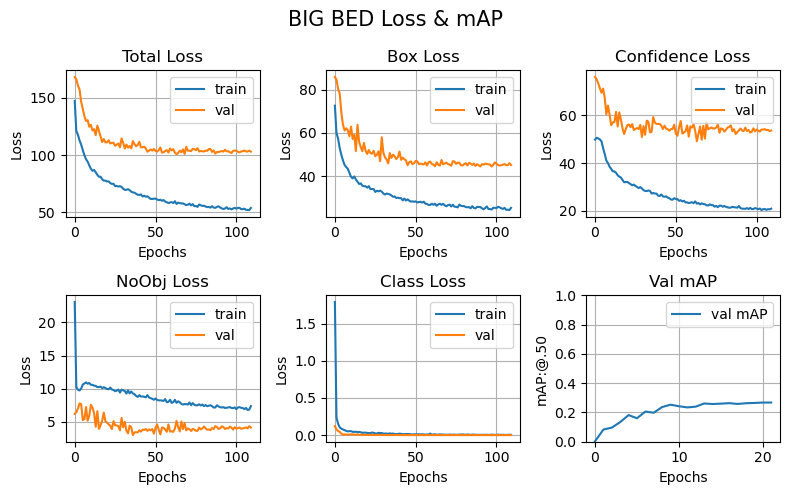

In [25]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(2,3, figsize=(8, 5))
fig.suptitle('BIG BED Loss & mAP', fontsize=15)

plt.subplot(2,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,2)
plt.plot(train_box_loss, label="train")
plt.plot(val_box_loss, label="val")
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.plot(train_confidence_loss, label="train")
plt.plot(val_confidence_loss, label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,4)
plt.plot(train_noobj_loss, label="train")
plt.plot(val_noobj_loss, label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,5)
plt.plot(train_class_loss, label="train")
plt.plot(val_class_loss, label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,6)
plt.plot(val_mAP, label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_loss_map.png")
plt.show()

In [26]:
# val_class_AP
# val_class_precision
# val_class_recall

smoke_prec = []
fire_prec = []
for prec in val_class_precision:
    smoke_prec.append(prec[0])
    fire_prec.append(prec[1])

smoke_recall = []
fire_recall = []
for rec in val_class_recall:
    smoke_recall.append(rec[0])
    fire_recall.append(rec[1])

smoke_ap = []
fire_ap = []
for ap in val_class_AP:
    smoke_ap.append(ap[0])
    fire_ap.append(ap[1])

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('BIG BED precision, recall, class AP')

plt.subplot(1, 3, 1)
plt.plot(smoke_prec, label="smoke")
plt.plot(fire_prec, label="fire")
plt.title("Precision")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(smoke_recall, label="smoke")
plt.plot(fire_recall, label="fire")
plt.title("Recall")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(smoke_ap, label="smoke")
plt.plot(fire_ap, label="fire")
plt.title("Class AP")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(log_path + "bed_precision_recall_classAP.png")
plt.show()

KeyError: 1